# Regression

In [40]:
import latenta as la
from latenta import distributions
import scanpy as sc
import numpy as np

We'll use the same dataset as [before](./1-variables)...

In [41]:
adata = la.data.load_myod1()
adata.obs["log_overexpression"] = np.log1p(adata.obs["overexpression"])
adata.var["label"] = adata.var["symbol"]
adata.raw = adata


## Easy things first: Linear regression

In the last tutorial, we learned the main types of variables, and how to connect these to construct a model:
- You either specify them at initialization: `la.Observation(p = ...)`
- Or connect them afterwards: `observation.p = ...`

We can now use these concepts to build a basic model of a transcriptome:

In [42]:
genes = la.Dim(adata.var)
cells = la.Dim(adata.obs)

In [43]:
overexpression = la.Fixed(adata.obs["log_overexpression"], label = "overexpression", symbol = "overexpression")

overexpression:  ↦ Fixed [cell (799)]

In [44]:
expression = la.links.scalar.Linear(
    overexpression,
    a = True,
    b = True,
    label = "expression",
    definition = la.Definition([cells, genes]),
    transforms = [la.transforms.Exp()]
)

Although the latent slope and baseline were created automatically for us by specifying `a = True, b = True`, it's important to remember that we could have easily created these variables ourselves:

```python
slope = la.Latent(
    p = la.distributions.Normal(scale = la.Parameter(1., transforms = [la.transforms.Exp()])),
    definition = la.Definition([genes])
)
```

In [45]:
dispersion = la.Latent(
    la.distributions.LogNormal(
        la.Parameter(0.),
        la.Parameter(1., transforms = [la.transforms.Exp()])
    ),
    definition = la.Definition([genes])
)

In [46]:
transcriptome_p = la.distributions.NegativeBinomial2(
    mu = expression,
    dispersion = dispersion
)

In [47]:
transcriptome = la.Observation(adata.X, transcriptome_p, definition = la.Definition([cells, genes]), label = "transcriptome")


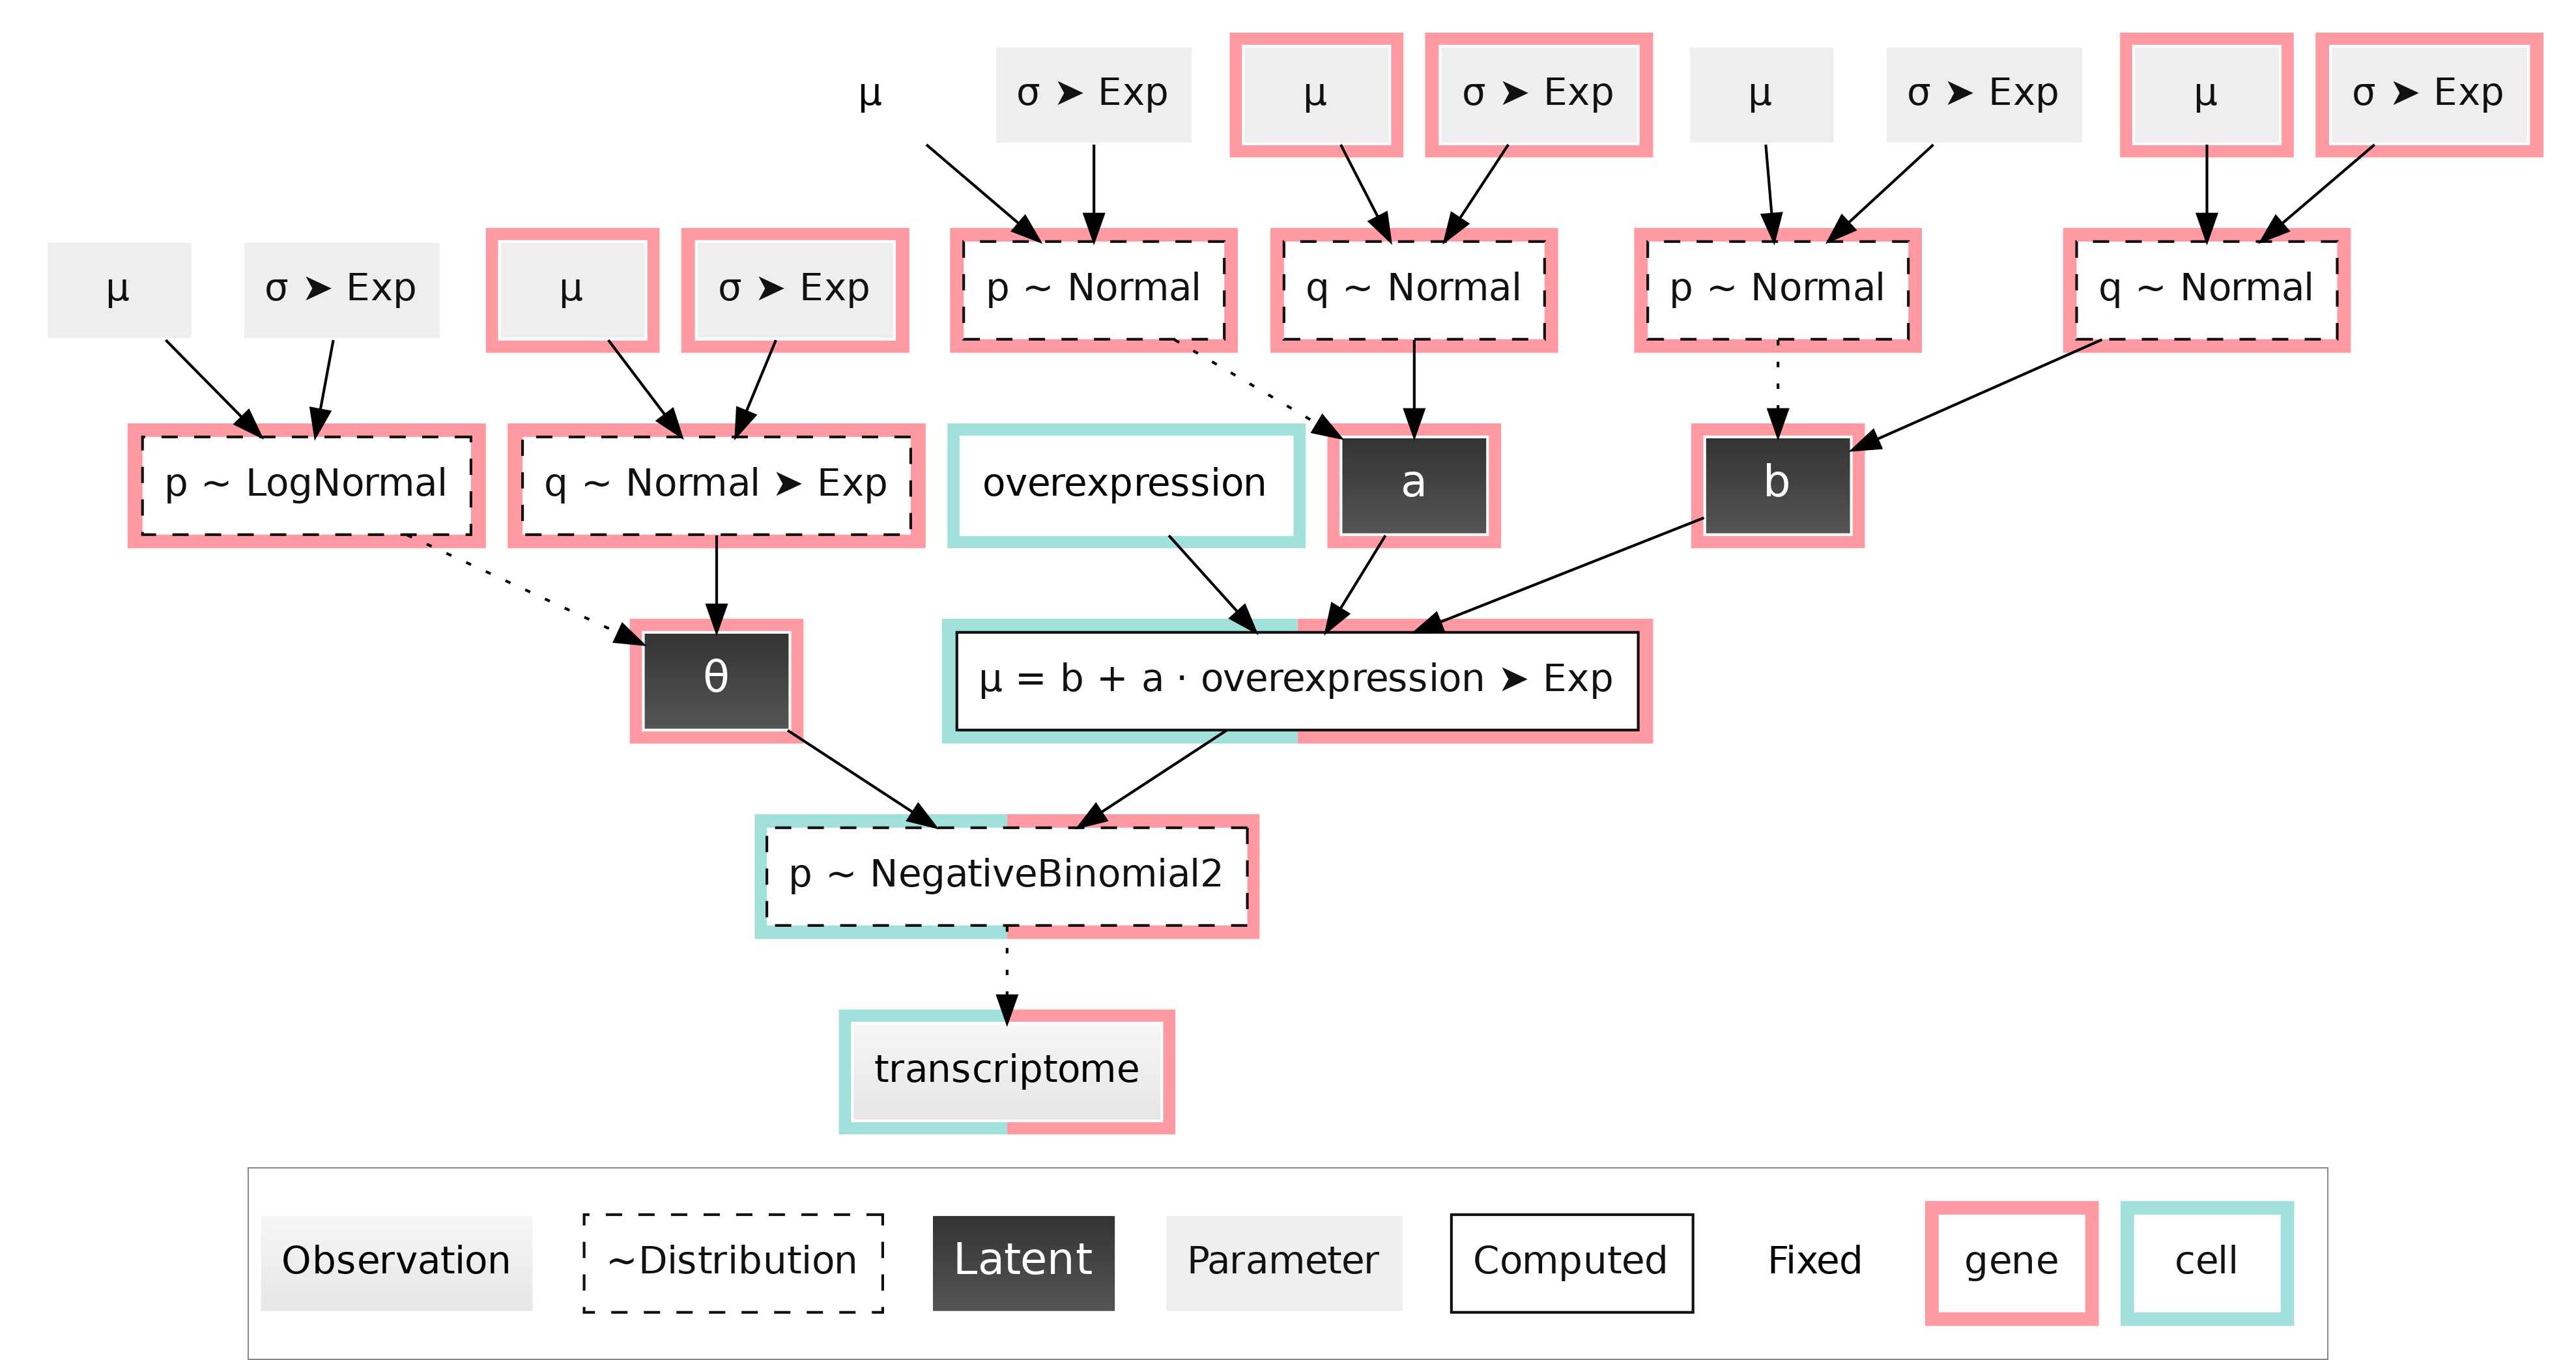

In [48]:
transcriptome.plot()

Note the many parameters that form the leaves of our model. But, why are there so many even for the simples of a simple case of linear regression?

Let's remind ourselves what we're actually trying to accomplish. We're trying to create a good model of our observations. There are however many models that will provide a very good fit of the data equally. For example, we could just give the actual count matrix as input to the negative binomial and this trivial model would fit extremely well.

So we don't just want a model. We want a model that can explain our observation well, while being both generalizeable and interpretable. And to accomplish his, we have to limit the flexibility that our model can have. You have already done this in two ways:

- Hard priors are those that completely constrain the model. For example, by specifying a linear function we don't allow any non-linearities.
- Soft priors are those that simply push the latent variables towards more likely values. For example, we want to discourage extreme slopes.

All these parameters thus serve two purposes: the parameters of the variational distributions $q$ will try to explain the observations while also remaining faithful to the prior distributions $p$. The parameters of $p$ on the other hand will try to accomodate the parameters of $q$ as well as possible, but it cannot do this perfectly as these parameters are shared across all genes. It's this pushing and pulling between priors and variational distributions that prevent overfitting and underfitting of the model. At the same time, we get some estimates of the uncertainty of our latent variables for free!

But how do we infer these parameters in practice? We have to find a solution that best balances the needs of the prior distribution with those of the observations. And one of the fastest ways to do that is to use gradient descent, which starts from an initial value and then tries to move these initial values slowly but surely into better values. These tasks are fullfilled by a loss function (`ELBO`), an optimizer (`Adam`), and an overarching training class (`SVI`):

In [49]:
inference = la.infer.svi.SVI(
    transcriptome,
    [la.infer.loss.ELBO()],
    la.infer.optim.Adam(lr = 0.05)
)
trainer = la.infer.trainer.Trainer(inference)

We can now train for a couple of iterations or until the loss function has reached a plateau (= converged):

  0%|                                                                                                         …

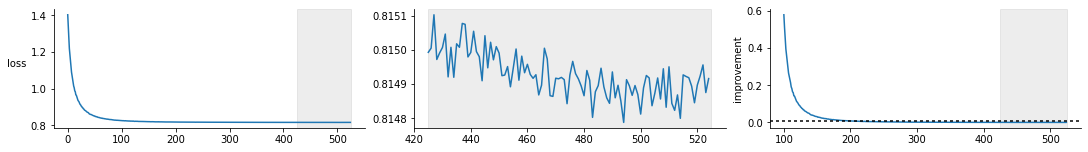

In [50]:
trace = trainer.train(10000)
trace.plot();

You can check that our values have changed:

In [56]:
transcriptome.p.mu.a.q.loc.run()
transcriptome.p.mu.a.q.loc.value_pd.head()

gene
ENSMUSG00000000031    1.013987
ENSMUSG00000000058   -0.160161
ENSMUSG00000000078   -0.093018
ENSMUSG00000000184   -0.036657
ENSMUSG00000000202    0.977628
                        ...   
ENSMUSG00000117278    0.226682
ENSMUSG00000117515    0.047154
ENSMUSG00000117710   -0.123128
ENSMUSG00000118106   -0.175916
ENSMUSG00000118365    0.002889
Length: 2047, dtype: float32


## Interpreting a regression model

For interpretation of the model, we can then use 3 main types of posteriors:

### Observed posteriors

Because we are working with a probabilistic model, every time we run through the model our results will change. For example, each time we run the variational distribution of the slope $q$ the output will be different, which will affect any downstream function even if they are themselves deterministic. To interpret the results, we can thus sample multiple times from the model:

In [ ]:
transcriptome_observed = la.posterior.Observed(transcriptome)
transcriptome_observed.sample(5)

`.samples` is a dictionary containing the samples of each variable that was upstream of the transcriptome. We can access each variable either by providing the variable itself or by providing a "breadcrumb" starting from the output variable:

In [ ]:
transcriptome_observed.samples[expression.a]

In [ ]:
transcriptome_observed.samples["transcriptome.p.mu.a"]

:::{note}
Latenta makes extensive use of the [xarray](https://xarray.pydata.org/en/stable/) library for annotated data in more than 2 dimensions. All samples are always stored as xr.DataArray objects. Important functions to know are:
- `.sel(dimension = [...])` to select a subset of the data
- `.to_pandas()` to convert a 2D or 1D array to a pandas DataFrame or Series
- `.dims` to get the dimensions of the data
- `.values` to get the values of a numpy array
- `.mean(dim = ...)` to get the mean of a dimension
- `xr.DataArray(..., dims = ['...'])` to construct a new DataArray
:::

In [ ]:

transcriptome_observed.samples[expression.a].mean("sample")

### Causal posteriors

To know how one variable influences another, we use a causal posterior. In essense, this posterior will set a variable of your choice to particular values, and then see how an output variables (and any intermediates) are affected. Latenta contains many different types of causal posteriors, which mainly differ in their visualization capabilities. Here we will use a `ScalarVectorCausal` posterior, because we are studying how a **scalar** variable (one value for each cell) impacts a **vector** (gene expression for each cell):

In [ ]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression,
    transcriptome
)
overexpression_causal.sample(10)

This posterior also contains samples, but now for some pseudocells with each a distinct value for the `overexpression` variable.

In [ ]:
overexpression_causal.samples[overexpression].mean("sample").head()

Depending on the type of causal posterior, you can plot the outcome. The `ScalarVectorCausal` can for example plot each individual _feature_ across all cells (in this case gene):

In [ ]:
overexpression_causal.plot_features();

This causal posterior can also provide a score dataframe that will rank each _feature_ (gene):

In [ ]:
overexpression_causal.scores

### Perturbed posteriors

To understand whether a variable has an important impact on the downstream variable, we use perturbed posteriors. These posteriors work in a very similar way as the observed posterior, but rather than using the actual value of the variable, it uses a perturbed version. The type of perturbation varies depending on which question we want to address, and can include random shuffling, random sampling from the prior, or conditionalizing on a fixed value.

While you can independently construct a perturbed posterior, you will typically create it indirectly through a causal posterior. For example, we can do random sampling using:

In [ ]:
overexpression_causal.sample_random()

To check the impact of a variable on our observation, we calculate a (log-)likelihood ratio: how much more likely is the observed expression before and after we perturbed our upstream variable?

In [ ]:
overexpression_causal.likelihood_ratio

These likelihood ratios were also added to our scores table:

In [ ]:
overexpression_causal.scores.head()

:::{note}
These likelihood ratios are mainly useful to understand the impact of a variable on an outcome *within a model*. In the model selection tutorial, we will introduce a more accurate measure to quantify whether a variable significantly affects an outcome, and whether this is significant compare to other simpler or more complex models.
:::

## Using _lacell_ to make model creation easier

Specific modalities in single-cell data typically require a similar way of normalization and statistical modelling, and we have collected such prototypical models into the `lacell` package. For example, we can directly construct a model for transcriptomics from an AnnData object as follows:

In [ ]:
import lacell as lac
transcriptome = lac.transcriptome.Transcriptome.from_adata(adata)
transcriptome.plot()

Note that this model is a bit more complex that the model we created before. In particular, it contains a library size normalization that will normalize the counts of each gene with a cell to the cell's total counts. However, the main ideas remain the same:

- We model the counts as a negative binomial distributions, with a dispersion $\theta$ and mean $\mu$.
- The mean $\mu$ is modelled as a linear combination of the relative expression in a cell $\rho$, and its library size $\textit{lib}$. The library size is set to the empirical library size (i.e. simply the sum of the counts in each cell).
- The $\rho$ itself is a linear combination of the average expression of each gene in the cell $\nu$, modelled as a latent variable, and the log-fold change $\delta$.
- When modelling cellular processes, we typically adapt the log-fold change $\delta$. However, you can also adapt any other variables, such as the library size or dispersion, if this makes sense from a biological or technical perspective.

:::{seealso}
[Why don't we just provide normalized data to latenta?](why-not-just-provide-normalized-data)
:::

## More complex regression problems

### Multiple inputs

### Non-linear